# Simulation
## Assignment 4.2 – Simulation-based optimization
#### Ari Viitala 432568

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
def inventory(s, d):
    #vectors for storing time and inventory history
    inventory = [60]
    times = [0]
    end = 120
    #current stock
    stock = 60
    #counters for storage and backlog penalties
    kept = 0
    backlog = 0
    #how many times we have ordered 
    order_count = 0
    #rate for demand and probabilities for it's magnitude
    demand_rate = 0.1
    probs = [1/6, 3/6, 5/6, 1]
    #first demand and supply which is at infinity
    demand = np.random.exponential(demand_rate)
    supply =  end + 1
    #simulation clock
    t = 0
    
    while t < end:
        #if demand is sooner than supply
        if demand < supply:
            #udate storage and backlog penalties
            if stock > 0:
                kept += (demand - t) * stock
            else:
                backlog -= (demand - t) * stock
            #update simulation clock   
            t = demand
            #draw the magnitude of demand
            amount = np.random.random()
            for i in range(0,4):
                if amount < probs[i]:
                    amount = i + 1
                    break
            #take the demand from stock
            stock -= amount 
            #draw a new demand time 
            demand = t + np.random.exponential(demand_rate)
            #update the histories
            times.append(t)
            inventory.append(stock)
            #if we have gone below the order limit and there is no order on the way then order 
            if stock < s and supply == end + 1:
                order_count += 1
                supply = t + np.random.uniform(0.5, 1)
        else:
            #update storage and backlog penalties
            if stock > 0:
                kept += (supply - t) * stock
            else:
                backlog -= (supply - t) * stock
            #update simulation clock
            t = supply 
            #add supply to stock
            stock += d
            #update histories
            times.append(t)
            inventory.append(stock)
            #if we have gone below order limit and even resupply didn't help. order more.
            if stock < s:
                order_count += 1
                supply = t + np.random.uniform(0.5, 1)
            #else set supply time to infinity
            else:
                supply = end + 1
    #if there is stock or backlog at the end of the simulation. count them too
    if stock > 0:
        kept += (end - t) * stock
    else:
        backlog -= (end - t) * stock
    #calculate the cost 
    cost = kept * 1 + backlog * 5 + order_count * (32 + d * 3)
    #return cost and histories
    return cost / end, times, inventory 

116.62906834269626


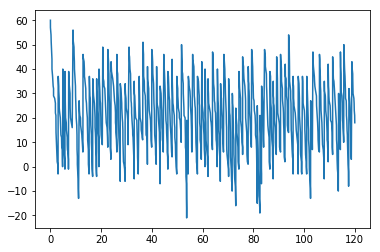

In [390]:
i = inventory(20, 40)
print(i[0])
plt.plot(i[1], i[2])
plt.show()

Looks reasonable and the cost is about what it was in exercise 2.2

### Optimization
I selected to do the optimization with some kind of variation of gradient descent. This probably is horribly inefficient since I invented it myself and because it has constant stepsize and only 8 directions but it works so I guess it is fine. 

In [391]:
def gradient(s, d, step, iterations):
    #the diagonal stepsize = step / sqrt(2)
    diag = round(step / 1.41, 0)
    #first we evaluate the function at the point where we want the derivative
    #by taking the average of different runs 
    current = 0
    for i in range(0, iterations):
        current += inventory(s,d)[0]
    current = current / iterations
    #then we calculate the slopes into different directions
    #if the function gets smaller values in one direction it gets negative slope
    dir = [0] * 8
    for i in range(0, iterations):
        dir[0] += (inventory(s - step, d)[0] - current)
        dir[1] += (inventory(s - diag, d - diag)[0] - current)
        dir[2] += (inventory(s, d - step)[0] - current)
        dir[3] += (inventory(s + diag, d - diag)[0] - current)
        dir[4] += (inventory(s + step, d)[0] - current)
        dir[5] += (inventory(s + diag, d + diag)[0] - current)
        dir[6] += (inventory(s, d + step)[0] - current)
        dir[7] += (inventory(s - diag, d + diag)[0] - current)
    #return the smallest slope and it's directions i.e. the direction of most rapid decresing
    return dir.index(min(dir)), min(dir) 

In [421]:
#start of the descent 
s = 90
d = 90
#stepsize
step = 5
#iterations per function value
iterations = 10
#initial gradient
direction, slope = gradient(s, d, step, iterations)
diag = round(np.sqrt(step), 0)
#store the values for drawing a path
S = [s]
D = [d]
#I am really not proud of the implementation but I didn't come up with anything better 
#this updates the variables s and d as long as there is a negative gradient to some direction
while slope < 0:
    if direction == 0:
        s -= step
    elif direction == 1:
        s -= diag
        d -= diag 
    elif direction == 2:
        d -= step
    elif direction == 3:
        s += diag
        d -= diag
    elif direction == 4:
        s += step
    elif direction == 5:
        s += diag
        d += diag
    elif direction == 6:
        d += step 
    else: 
        d += diag
        s -= diag
    #store s and d
    S.append(s)
    D.append(d)
    #calculate a new gradient 
    direction, slope = gradient(s, d, step, iterations)

In [422]:
print("Optimal value for s: " + str(s))
print("Optimal value for d: " + str(d))
counter = 0
for i in range(0,50):
    counter += inventory(s,d)[0]
print("Value at optimum: " + str(counter / 50))

Optimal value for s: 12.0
Optimal value for d: 52.0
Value at optimum: 115.531302789


The result seems plausible. Let's check how the gradient descent progresses.

In [357]:
#calculating the average value of the function in every location and storing it in an array
runs = 3
s_lo = 0
s_hi = 100
d_lo = 15
d_hi = 100
sweep = np.empty((s_hi - s_lo, d_hi - d_lo), float)
for i in range(s_lo,s_hi):
    for j in range(d_lo, d_hi):
        counter = 0
        for k in range(0, runs):
            counter += inventory(i, j)[0]
        sweep[i - s_lo, j - d_lo] = counter / runs

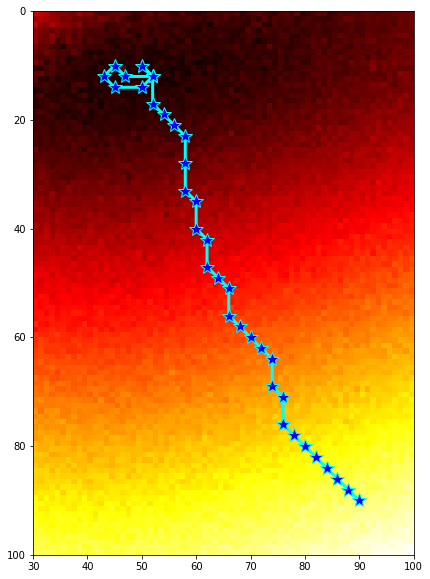

In [423]:
#plotting the heatmap of the function values and adding the path of the gradient descent 
plt.figure(1, (10,10))
imgplot = plt.imshow(sweep[:, 15:], extent = (30,100, 100, 0))
imgplot.set_cmap('hot')
plt.plot(D, S, "cyan", linewidth = 3.0, marker = "*", markersize = 15.0, mfc = "b")
plt.show()

The gradient descent seems to find to the bottom of the pit. Also here we evaluate the gradient at roughly 30 points and each of those requires 90 function evaluations at 10 iterations per funtion. This means that the total amount of function evaluations is about 2500 where as bruteforcing the whole grid with just one function evaluation per point would require close to 10000 function evaluations. This means that roughly speaking, my method is 4 times faster.